In [1]:
from lsst.rsp import get_tap_service

Following, eg, Andrés's tutorial, let's do the usual join of SSObject and MPCORB, taking `FLAG < 2048` to select on linked objects. Note that this is, on purpose, excluding the spaceships as they are not on MPCORB

In [2]:
service = get_tap_service("ssotap")
allobj = service.search("SELECT mpc.ssObjectId, mpc.e, mpc.incl, mpc.q, "
                      "mpc.node, mpc.peri, sso.* "
                      "FROM dp03_catalogs_10yr.MPCORB as mpc "
                      "JOIN dp03_catalogs_10yr.SSObject as sso "
                      "ON mpc.ssObjectId = sso.ssObjectId "
                      f"WHERE sso.flags < 2048 ").to_table()
print(len(allobj))


4222090


In [3]:
allobj.info()

<Table length=4222090>
          name           dtype   unit                                                                                                description                                                                                                 n_bad 
----------------------- ------- ------ -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- -------
             ssObjectId   int64                                                                                                                                                                    LSST unique identifier (if observed by LSST)       0
                      e float64                                                                                                                                                                                    MPCORB: Orbital eccent

Simplified population splits, there might be interlopers in each population and objects that fall in the gaps but that's fine for our purposes
- NEOs: $q < 1.3$ au
- MBAs: $2.0 < a < 3.5$ au and $q > 1.3$ au (to avoid the NEOs
- Hildas: $3.7 < a < 4.2 $ au and $q > 1.3$ au (to avoid the NEOs)
- Jupiter Trojans: $5.05 < a <  5.35$ au and $q > 1.3$ au (to avoid the NEOs)
- Centaurs: $a < 30$ au and $ q > 5 $ au (beyond Jupiter but before Neptune)
- TNOs: $ a> 30 $ au and $q > 20$ au (to avoid the LPCs)
- LPCs: $a > 30$ au and $ q < 20$ au 
- ISOs: $ e > 1$


In [4]:
allobj['a'] = allobj['q']/(1-allobj['e'])

In [5]:
selections = {'NEO' : lambda x : x[x['q'] < 1.3], 'MBA' : lambda x : x[(x['a'] < 3.5) & (x['a'] > 2) & (x['q'] > 1.3)],\
              'Hilda' : lambda x : x[(x['a'] < 4.2) & (x['a'] > 3.7) & (x['q'] > 1.3)],\
              'Jupiter Trojan' : lambda x : x[(x['a'] < 5.35) & (x['a'] > 5.05) & (x['q'] > 1.3)],\
              'Centaur' : lambda x : x[(x['a'] < 30) & (x['q'] > 5)], 'TNO' : lambda x : x[(x['a'] > 30) & (x['q'] > 20)],
              'LPC' : lambda x : x[(x['a'] > 30) & (x['q'] < 20)], 'ISO' : lambda x : x[x['e'] > 1]}

In [6]:
subsets = {i : selections[i](allobj) for i in selections}

In [7]:
for i in subsets:
    print(i, len(subsets[i]))

NEO 37578
MBA 3974030
Hilda 26750
Jupiter Trojan 86201
Centaur 18852
TNO 22738
LPC 3310
ISO 2170


In [8]:
import matplotlib.pyplot as pl 
import numpy as np 
pl.style.use('/home/phbern/custom.mplstyle') #Pedro's custom matplotlib style

## Number of observations
Let's look into number of observations first. I am capping at 600 observations to avoid having things that fall in the deep drilling fields.

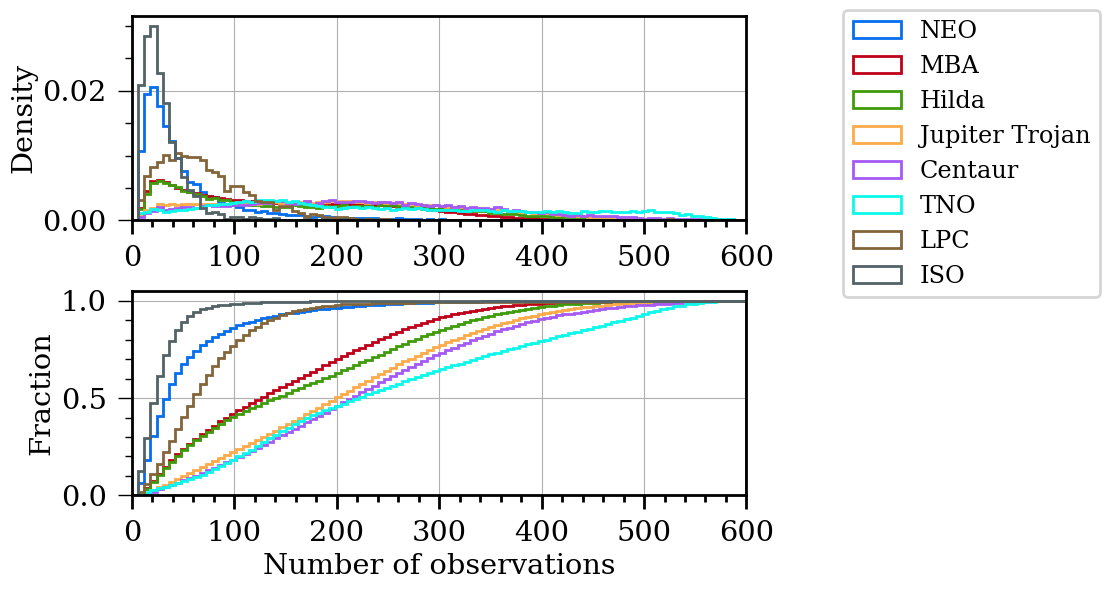

In [9]:
fig, ax = pl.subplots(2,1)
for i in subsets:
    ax[0].hist(subsets[i]['numObs'], bins=100, histtype='step', density = True, range=(0,600), label = i)
    ax[1].hist(subsets[i]['numObs'], bins=100, histtype='step', density = True, range=(0,600), cumulative = True)

ax[0].set_xlim(0,600)
ax[1].set_xlim(0,600)

ax[0].grid()
ax[1].grid()
pl.xlabel('Number of observations')
ax[0].set_ylabel('Density')
ax[1].set_ylabel('Fraction')
fig.tight_layout()
fig.legend(bbox_to_anchor =(1.4, 1.))

pl.show()

In [10]:
for i in subsets:
    print(f"{i} Mean: {np.mean(subsets[i]['numObs']):.1f} Median: {np.median(subsets[i]['numObs']):.0f} Min: {np.min(subsets[i]['numObs'])} Max: {np.max(subsets[i]['numObs'])}")

NEO Mean: 56.3 Median: 36 Min: 6 Max: 1708
MBA Mean: 151.8 Median: 130 Min: 6 Max: 3228
Hilda Mean: 170.8 Median: 145 Min: 6 Max: 2771
Jupiter Trojan Mean: 227.2 Median: 206 Min: 6 Max: 3435
Centaur Mean: 243.4 Median: 221 Min: 6 Max: 7414
TNO Mean: 258.7 Median: 225 Min: 6 Max: 12103
LPC Mean: 76.1 Median: 64 Min: 6 Max: 1203
ISO Mean: 30.5 Median: 25 Min: 6 Max: 305


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [11]:
ugrizy = ['u', 'g', 'r', 'i', 'z', 'y']

In [12]:
for i in subsets:
    print(i)
    for b in ugrizy:
        n = subsets[i][f'{b}_Ndata']
        print(f"{b} Mean: {np.mean(n):.1f} Median: {np.median(n):.0f}")

NEO
u Mean: 0.0 Median: 0
g Mean: 5.7 Median: 0
r Mean: 18.4 Median: 12
i Mean: 16.5 Median: 11
z Mean: 9.6 Median: 6
y Mean: 0.0 Median: 0
MBA
u Mean: 0.0 Median: 0
g Mean: 20.8 Median: 20
r Mean: 54.3 Median: 50
i Mean: 47.4 Median: 40
z Mean: 28.0 Median: 18
y Mean: 0.0 Median: 0
Hilda
u Mean: 0.0 Median: 0
g Mean: 24.9 Median: 24
r Mean: 61.0 Median: 57
i Mean: 52.3 Median: 42
z Mean: 31.2 Median: 19
y Mean: 0.0 Median: 0
Jupiter Trojan
u Mean: 0.0 Median: 0
g Mean: 34.7 Median: 33
r Mean: 83.6 Median: 79
i Mean: 70.1 Median: 63
z Mean: 37.6 Median: 25
y Mean: 0.0 Median: 0
Centaur
u Mean: 0.0 Median: 0
g Mean: 32.0 Median: 32
r Mean: 77.7 Median: 77
i Mean: 65.4 Median: 60
z Mean: 35.1 Median: 22
y Mean: 0.0 Median: 0
TNO
u Mean: 0.0 Median: 0
g Mean: 0.0 Median: 0
r Mean: 0.0 Median: 0
i Mean: 0.0 Median: 0
z Mean: 0.0 Median: 0
y Mean: 0.0 Median: 0
LPC
u Mean: 0.0 Median: 0
g Mean: 7.9 Median: 7
r Mean: 23.4 Median: 21
i Mean: 21.1 Median: 19
z Mean: 13.0 Median: 12
y Mean: 0.0

Note that this is an underestimate - we only record this number for band $b$ if the object has its $H$ magnitude fit in band $b$ - hence why the numbers for TNOs are all 0.

## Arcs

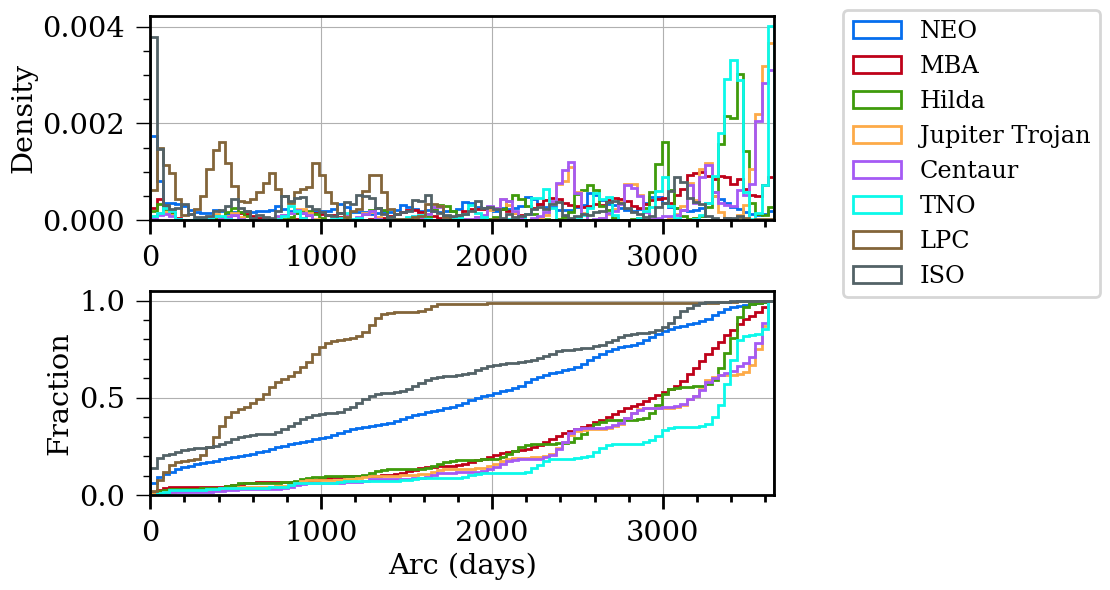

In [13]:
fig, ax = pl.subplots(2,1)
for i in subsets:
    ax[0].hist(subsets[i]['arc'], bins=100, histtype='step', density = True, range=(0,3650), label = i)
    ax[1].hist(subsets[i]['arc'], bins=100, histtype='step', density = True, range=(0,3650), cumulative = True)

ax[0].set_xlim(0,3650)
ax[1].set_xlim(0,3650)

ax[0].grid()
ax[1].grid()
pl.xlabel('Arc (days)')
ax[0].set_ylabel('Density')
ax[1].set_ylabel('Fraction')
fig.tight_layout()
fig.legend(bbox_to_anchor =(1.4, 1.))

pl.show()

These curves look very similar to the survival function of the discovery date histograms below - not surprising.

## Discovery dates

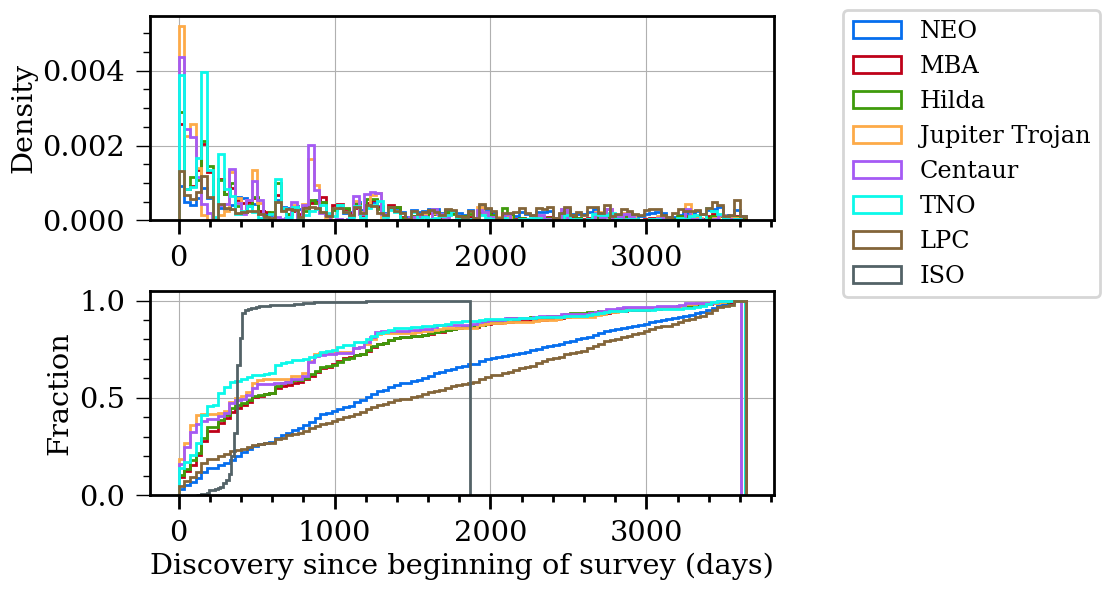

In [14]:
fig, ax = pl.subplots(2,1)
mindate = np.min(allobj['discoverySubmissionDate'])

for i in subsets:
    if i != 'ISO':
        ax[0].hist(subsets[i]['discoverySubmissionDate'] - mindate, bins=100, histtype='step', density = True)
    ax[1].hist(subsets[i]['discoverySubmissionDate']-mindate, bins=100, histtype='step', density = True, cumulative = True, label = i)

#ax[0].set_xlim(0,500)
#ax[1].set_xlim(0,500)

ax[0].grid()
ax[1].grid()
pl.xlabel('Discovery since beginning of survey (days)')
ax[0].set_ylabel('Density')
ax[1].set_ylabel('Fraction')
fig.tight_layout()
fig.legend(bbox_to_anchor =(1.4, 1.))

pl.show()

Note that the ISO dates are probably a bug due to Ari's ISO population having their perihelia near ~500 days after the start of the survey.

Interesting to see that the LPCs and NEOs have similar continuous fluxes, and their 50% discovery rate comes only after ~half the survey. On the other hand, the other populations (especially TNOs) peak near the first year or so of observations

## Absolute magnitudes and colors
For the NEOs, MBAs, Hildas and Trojans, we should have a wide variety of phase coverage, so $H_b$ should be fit for most $b$. Let's use the flags for that...

In [15]:
flags = {'u' : 2, 'g' : 4, 'r' : 8, 'i' : 16, 'z': 32, 'y' : 64}

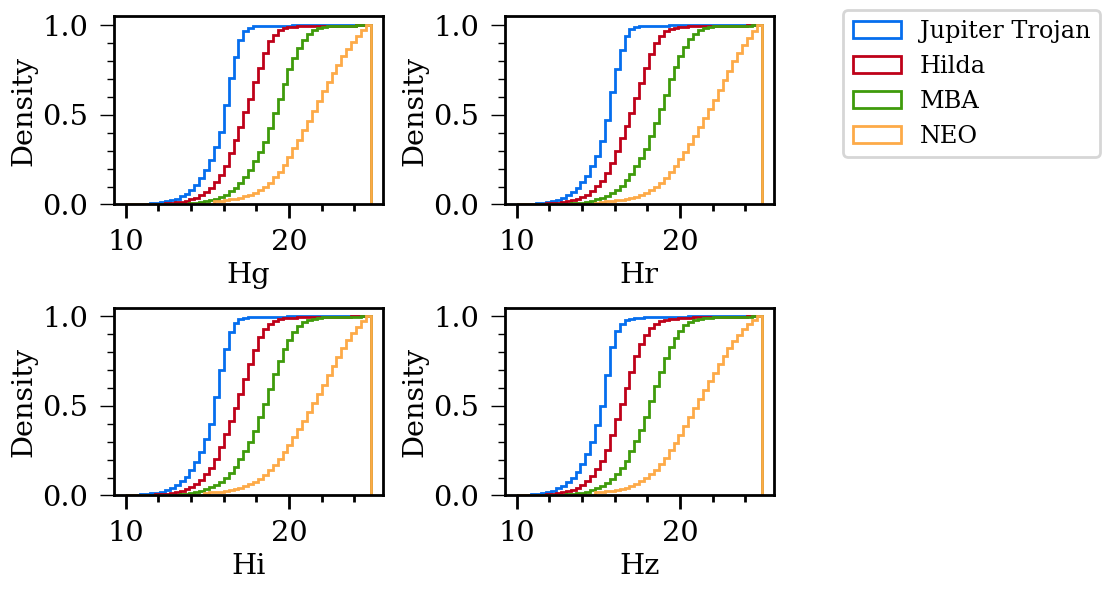

In [17]:
fig, ax = pl.subplots(2,2)
fl = ax.flatten()
griz = ['g', 'r', 'i', 'z']
for i in reversed(['NEO', 'MBA', 'Hilda', 'Jupiter Trojan']):
    k = 0
    for b in griz:
        sel = subsets[i][subsets[i]['flags'] & flags[b] != flags[b]]
        if k == 1:
            fl[k].hist(sel[f'{b}_H'], density = True, cumulative = True, histtype='step', bins=50, range=(10,25), label=i)
        else:
            fl[k].hist(sel[f'{b}_H'], density = True, cumulative = True, histtype='step', bins=50, range=(10,25))
        if i == 'NEO':
            fl[k].set_xlabel(f'H{b}')
            fl[k].set_ylabel('Density')
        k += 1

fig.tight_layout()
fig.legend(bbox_to_anchor =(1.4, 1.))

pl.show()


This shows the trend we expect: we're finding smaller objects closer to the Sun. Good sign!

Colors are **weird**.

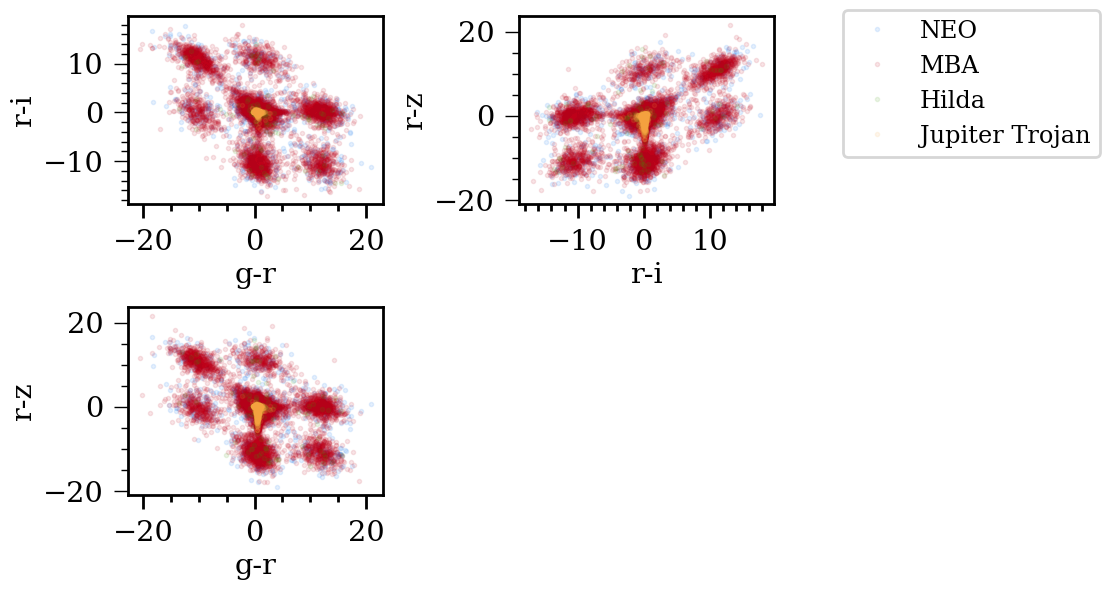

In [18]:
fig, ax = pl.subplots(2,2)
for i in ['NEO', 'MBA', 'Hilda', 'Jupiter Trojan']:
    k = 0
    sel = subsets[i]
    for b in griz:
        sel = sel[sel['flags'] & flags[b] != flags[b]]    
    ax[0,0].plot(sel['g_H'] - sel['r_H'], sel['r_H'] - sel['i_H'],'.', alpha=0.1, label=i)
    ax[1,0].plot(sel['g_H'] - sel['r_H'], sel['r_H'] - sel['z_H'],'.', alpha=0.1)
    ax[0,1].plot(sel['r_H'] - sel['i_H'], sel['r_H'] - sel['z_H'], '.', alpha=0.1)
ax[0,0].set_xlabel('g-r')
ax[0,0].set_ylabel('r-i')
ax[1,0].set_xlabel('g-r')
ax[1,0].set_ylabel('r-z')
ax[0,1].set_xlabel('r-i')
ax[0,1].set_ylabel('r-z')
fig.legend(bbox_to_anchor =(1.4, 1.))

ax[1,1].axis('off')
fig.tight_layout()

pl.show()


These look like we have a few spectacular failure modes where the $H_b$ fail in one or more bands, in multiple directions. What happens if we select on uncertainties as well?

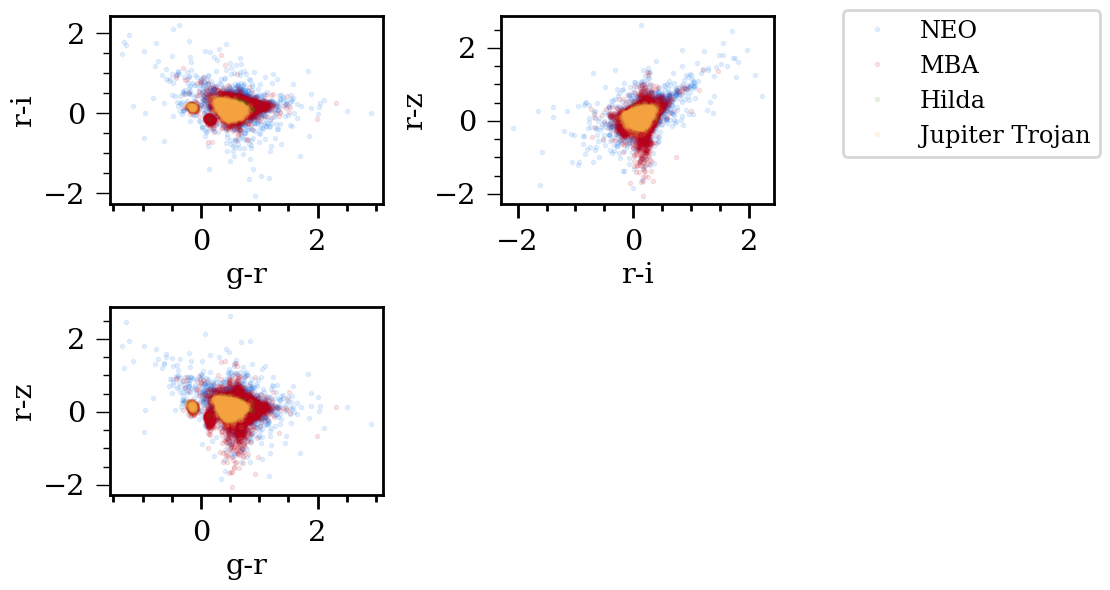

In [21]:
fig, ax = pl.subplots(2,2)
for i in ['NEO', 'MBA', 'Hilda', 'Jupiter Trojan']:
    k = 0
    sel = subsets[i]
    for b in griz:
        sel = sel[sel['flags'] & flags[b] != flags[b]]   
        sel = sel[sel[f'{b}_HErr'] < 0.3]
        sel = sel[sel[f'{b}_G12Err'] < 1]
    ax[0,0].plot(sel['g_H'] - sel['r_H'], sel['r_H'] - sel['i_H'],'.', alpha=0.1, label=i)
    ax[1,0].plot(sel['g_H'] - sel['r_H'], sel['r_H'] - sel['z_H'],'.', alpha=0.1)
    ax[0,1].plot(sel['r_H'] - sel['i_H'], sel['r_H'] - sel['z_H'], '.', alpha=0.1)
ax[0,0].set_xlabel('g-r')
ax[0,0].set_ylabel('r-i')
ax[1,0].set_xlabel('g-r')
ax[1,0].set_ylabel('r-z')
ax[0,1].set_xlabel('r-i')
ax[0,1].set_ylabel('r-z')
fig.legend(bbox_to_anchor =(1.4, 1.))

ax[1,1].axis('off')
fig.tight_layout()

pl.show()


Much more reasonable.

Let me take a look at one of these weirdos in the MBA distribution

In [24]:
sel = subsets['MBA']
for b in griz:
    sel = sel[sel['flags'] & flags[b] != flags[b]]   

sel[np.argmax(sel['g_H'] - sel['r_H'])]['ssObjectId', 'g_H', 'g_HErr', 'r_H', 'r_HErr', 'numObs']

ssObjectId,g_H,g_HErr,r_H,r_HErr,numObs
,mag,mag,mag,mag,
int64,float32,float32,float32,float32,int32
-5117219044480295240,40.534462,876152.9,21.568928,1.1793475,36


In [36]:
trash = service.search("SELECT dia.mag, dia.magErr, dia.band, dia.midPointMjdTai, dia.magTrueVband, ss.phaseAngle, "
                        "ss.heliocentricX, ss.heliocentricY, ss.heliocentricZ, "
                        "ss.topocentricX, ss.topocentricY, ss.topocentricZ "
                        "FROM dp03_catalogs_10yr.DiaSource AS dia "
                        "JOIN dp03_catalogs_10yr.SSSource AS ss ON dia.diaSourceId = ss.diaSourceId "
                        "WHERE dia.ssObjectId = -5117219044480295240").to_table()




In [37]:
trash

mag,magErr,band,midPointMjdTai,magTrueVband,phaseAngle,heliocentricX,heliocentricY,heliocentricZ,topocentricX,topocentricY,topocentricZ
,,,d,,deg,AU,AU,AU,AU,AU,AU
float32,float32,str1,float64,float32,float32,float32,float32,float32,float32,float32,float32
26.315,3.362,i,61382.33018,28.918442,19.419586,-1.8771155,2.0893745,0.55602604,-2.1178157,1.2128725,0.17611381
29.945,5.296,z,61583.95555,29.275574,17.989723,-2.6273453,0.5438012,0.11013325,-2.728076,1.4719192,0.51247406
34.698,4.178,z,61404.36048,28.536345,16.004087,-2.0179505,1.9611813,0.5177527,-1.8763839,1.0683173,0.13073972
24.424,3.267,i,61404.33013,28.53694,16.011065,-2.0177648,1.9613663,0.51780766,-1.8767267,1.0684257,0.13076416
27.134,3.885,z,61394.26975,28.723324,17.940912,-1.9549216,2.0214353,0.5356893,-1.9892542,1.1192604,0.14465445
29.219,2.935,i,61414.32186,28.334028,13.4445715,-2.0776262,1.8992257,0.49939337,-1.7666949,1.0431995,0.12834999
30.733,2.947,i,61407.3347,28.477667,15.307431,-2.0360372,1.9429373,0.5123382,-1.8432151,1.0582143,0.12885444
27.338,3.211,i,61490.08218,28.398018,15.863082,-2.440287,1.3554211,0.34089142,-1.4464531,1.4321516,0.37417442


Why the heck is this thing being detected?????

Let me look into the other direction

In [38]:
sel[np.argmin(sel['g_H'] - sel['r_H'])]['ssObjectId', 'g_H', 'g_HErr', 'r_H', 'r_HErr', 'numObs']

ssObjectId,g_H,g_HErr,r_H,r_HErr,numObs
,mag,mag,mag,mag,
int64,float32,float32,float32,float32,int32
4571516276700198619,17.376505,1.4670482,37.926662,382643.34,58


In [39]:
trash = service.search("SELECT dia.mag, dia.magErr, dia.band, dia.midPointMjdTai, dia.magTrueVband, ss.phaseAngle, "
                        "ss.heliocentricX, ss.heliocentricY, ss.heliocentricZ, "
                        "ss.topocentricX, ss.topocentricY, ss.topocentricZ "
                        "FROM dp03_catalogs_10yr.DiaSource AS dia "
                        "JOIN dp03_catalogs_10yr.SSSource AS ss ON dia.diaSourceId = ss.diaSourceId "
                        "WHERE dia.ssObjectId = 4571516276700198619").to_table()




In [40]:
trash

mag,magErr,band,midPointMjdTai,magTrueVband,phaseAngle,heliocentricX,heliocentricY,heliocentricZ,topocentricX,topocentricY,topocentricZ
,,,d,,deg,AU,AU,AU,AU,AU,AU
float32,float32,str1,float64,float32,float32,float32,float32,float32,float32,float32,float32
26.97,3.735,g,61178.97622,29.077753,31.276258,-1.920868,-0.007504206,-0.29195982,-1.3797169,0.7766766,0.047994997
32.18,3.548,r,61180.99597,29.124825,31.214184,-1.9245852,-0.020462668,-0.31341466,-1.4125521,0.78043497,0.0337835
22.913,3.362,r,61178.99353,29.078167,31.27594,-1.9209012,-0.007615304,-0.29214397,-1.3799957,0.7767165,0.047874667
27.792,3.989,i,61585.39782,29.553522,18.326822,0.6091698,-1.3446355,-2.0812595,0.4841063,-0.4189518,-1.6799738
26.603,4.816,i,61672.00155,29.934404,24.203985,1.3003037,-1.1610446,-1.684225,0.2969152,-1.1666222,-1.6866283
26.416,3.469,r,61176.99489,29.030317,31.318842,-1.9169143,0.0052089575,-0.27086645,-1.3478093,0.7721043,0.061594237
30.839,3.431,i,61175.00173,28.981302,31.341963,-1.9126275,0.017997192,-0.24960336,-1.3160516,0.7666266,0.074938565
28.975,3.345,r,61178.99437,29.078186,31.275923,-1.9209028,-0.007620651,-0.29215282,-1.3800092,0.77671844,0.047868874
